Install and import necessary packages

In [1]:
!pip install pandas
!pip install tensorflow
!pip install transformers
!pip install scikit-learn
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense,Dropout, Input
from sklearn.metrics import confusion_matrix,f1_score,classification_report,accuracy_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

2023-02-27 01:38:03.691874: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-27 01:38:03.691940: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-27 01:38:03.691947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


A mapping from the 28 emotions to postivie,negative,neutral and ambiguous

In [2]:
ob = {
"positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}
flse={0:'admiration',
1:'amusement',
2:'anger',
3:'annoyance',
4:'approval',
5:'caring',
6:'confusion',
7:'curiosity',
8:'desire',
9:'disappointment',
10:'disapproval',
11:'disgust',
12:'embarrassment',
13:'excitement',
14:'fear',
15:'gratitude',
16:'grief',
17:'joy',
18:'love',
19:'nervousness',
20:'optimism',
21:'pride',
22:'realization',
23:'relief',
24:'remorse',
25:'sadness',
26:'surprise',
27:'neutral'}
0

0

load the dataset (GoEmotions)

In [3]:
st = pd.read_csv("train (1).tsv",sep='\t',header=None)
sv = pd.read_csv("test (1).tsv",sep='\t',header=None)

Change the labels from emotion to sentiment

In [4]:
#loop through the data and convert the labels from numerical to the emotions
emot = []
for s in st[1]:
  emot.append(flse[int(s.split(",")[0])])

valemot = []
for s in sv[1]:
  valemot.append(flse[int(s.split(",")[0])])


#take these labels as emotions and map them to positive, negative, neutral and ambiguous
SeT = []
for u in emot:
  if u in ob['positive']:
    SeT.append(1)
  elif u in ob['negative']:
    SeT.append(2)
  elif u in ob['ambiguous']:
    SeT.append(3)
  else:
    SeT.append(0)

st['label'] = SeT

SeV = []
for u in valemot:
  if u in ob['positive']:
    SeV.append(1)
  elif u in ob['negative']:
    SeV.append(2)
  elif u in ob['ambiguous']:
    SeV.append(3)
  else:
    SeV.append(0)
sv['label'] = SeV

Load the BERT network in

In [5]:
emert_model = TFAutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
emert_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


convert to numpy array and format the labels

In [6]:
sv = sv.dropna()
lt = st['label']
lv = sv['label']
lt = lt.to_numpy()
lv = lv.to_numpy()
labels_train = lt
labels_test = lv
train_labels = tf.keras.utils.to_categorical(labels_train, num_classes=4)
test_labels = tf.keras.utils.to_categorical(labels_test, num_classes=4)

define a set tokenizer

In [7]:
def tokener(u,L):
    ids=[]
    masks=[]
    for a in u:
        T=emert_tokenizer.encode_plus(a,add_special_tokens = True,max_length =L,pad_to_max_length = True,return_attention_mask = True,truncation=True,verbose=False)
        ids.append(T['input_ids'])
        masks.append(T['attention_mask'])
    ids=np.asarray(ids)
    masks=np.array(masks)

    return [ids,masks]

tokenize the train and test sets

In [9]:
max_len = 65

In [10]:
[input_train,mask_train] = tokener(st[0],max_len)
[input_test,mask_test] = tokener(sv[0],max_len)

Create and compile our model

In [11]:
inps = Input(shape = (max_len,), dtype='int64')
masks= Input(shape = (max_len,), dtype='int64')
dbert = emert_model(inps, attention_mask=masks)[1]

L3 = tf.keras.layers.Dense(units=768)(dbert)

L2 = tf.keras.layers.Dropout(0.15)(L3)
L1 = tf.keras.layers.Dense(units=768)(L2)
fin = tf.keras.layers.Dropout(0.2)(L1)

output = tf.keras.layers.Dense(units=4,activation='softmax',name="final")(fin)
model = tf.keras.Model(inputs=[inps,masks], outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 65,                                            

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss=loss,optimizer=optimizer,metrics=["categorical_accuracy"])

Train the model, and test performnce after each epoch

170/170 [==============================] - 24s 124ms/step
F1: 0.691466277569694
accuracy: 0.7178920213746084
precision 0.6871044873978841
recall 0.6982104136430083


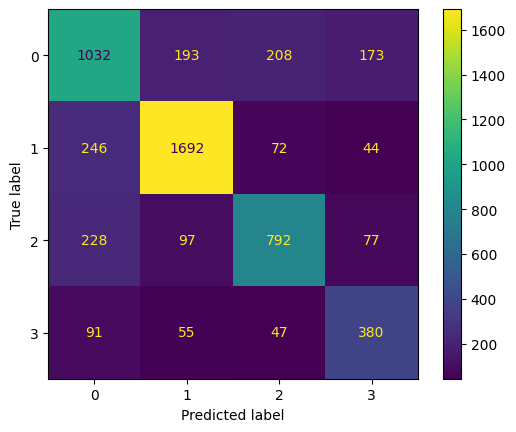

In [13]:
model.fit([input_train,mask_train],train_labels,batch_size=15,epochs=1)
predictions = model.predict([input_test,mask_test])
labels = np.argmax(predictions,axis=1)
print('F1:',f1_score(labels_test,labels,average='macro'))
print('accuracy:',accuracy_score(labels_test,labels))
print('precision',precision_score(labels_test,labels,average='macro'))
print('recall',recall_score(labels_test,labels,average='macro'))
ConfusionMatrixDisplay.from_predictions(labels_test,labels)

170/170 [==============================] - 21s 121ms/step
F1: 0.6901328090283821
accuracy: 0.7202874516307353
precision 0.6902532120745396
recall 0.7000870738562752


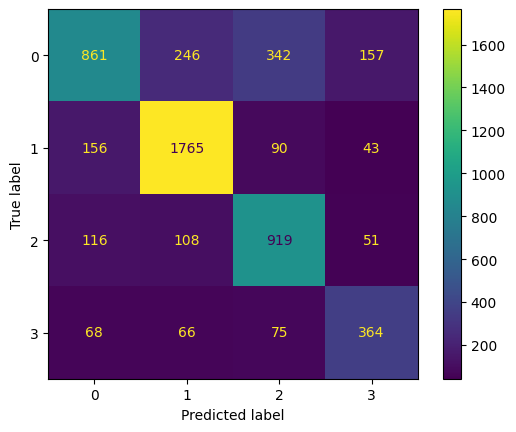

In [14]:
model.fit([input_train,mask_train],train_labels,batch_size=15,epochs=1)
predictions = model.predict([input_test,mask_test])
labels = np.argmax(predictions,axis=1)
print('F1:',f1_score(labels_test,labels,average='macro'))
print('accuracy:',accuracy_score(labels_test,labels))
print('precision',precision_score(labels_test,labels,average='macro'))
print('recall',recall_score(labels_test,labels,average='macro'))
ConfusionMatrixDisplay.from_predictions(labels_test,labels)

Read in the data

In [15]:
data = pd.read_pickle('sent-data.pkl')

In [17]:
data[1]

0    ["everyone hates us for some reason, we just t...
1    [This is a 6-year old news just repeated in a ...
2    [Oh no, Romania is so corrupt I can do whateve...
3    [How did it affect the gas price in Czechia?, ...
4    [OP, who pissed on your coffee on this fine Mo...
5    [I didn't know one of the Nato requirements wa...
6    [Boycott Heineken. Real simple., Heineken also...
7    ["But Mom! I'm not even tired..ZZZZ", Is it ju...
8    [This is the cat equivalent of the meme with t...
Name: 1, dtype: object

use the model to predict the sentiment of the comments

In [19]:
sents = []
for a in data[1]:
    [i,m] = tokener(a,max_len)
    predictions = model.predict([i,m])
    sents.append(predictions)


9/9 [==============================] - 1s 119ms/step


generate statistics from the predicted sentiments

In [20]:
avgs = []
for a in sents:
    avgs.append(np.mean(a,axis=0))
medians = []
for a in sents:
    medians.append(np.median(a,axis=0))
std = []
for a in sents:
    std.append(np.std(a,axis=0))


In [24]:
feel = {0:'neutral',1:'positive',2:'negative',3:'ambiguous'}


In [41]:
from statistics import mode

labelled_as = []
for a in range(0,9):
    S = []
    sentiments = np.argmax(sents[a],axis=1)
    for b in sentiments:
        S.append(feel[b])
    labelled_as.append(S) 
most_common_sentiment = []
for a in range(0,9):
    most_common_sentiment.append(mode(labelled_as[a]))

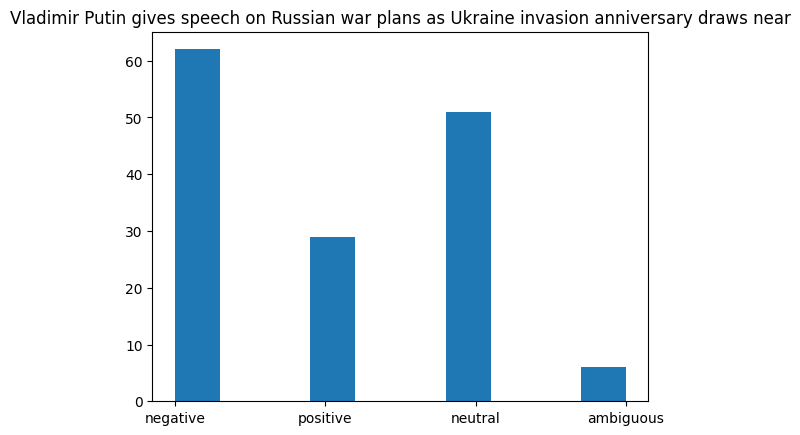

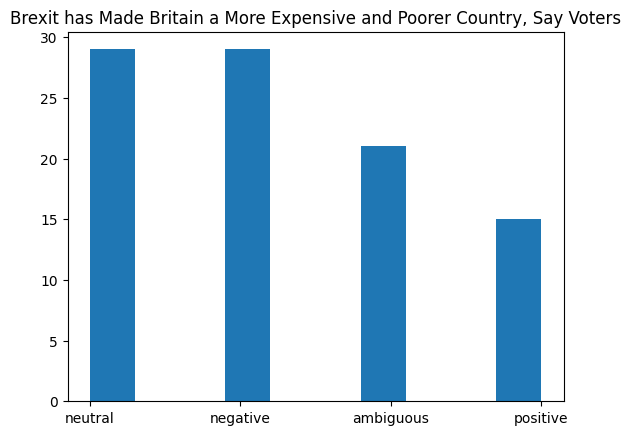

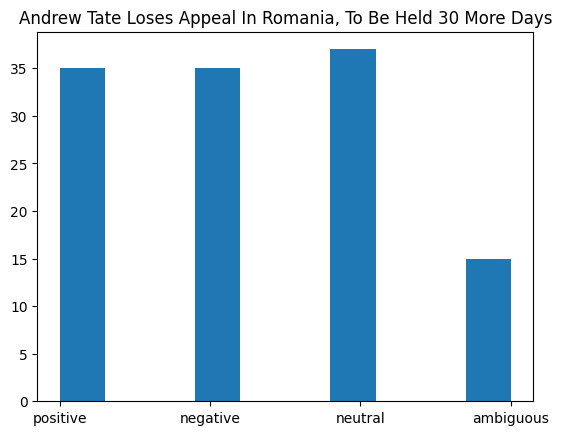

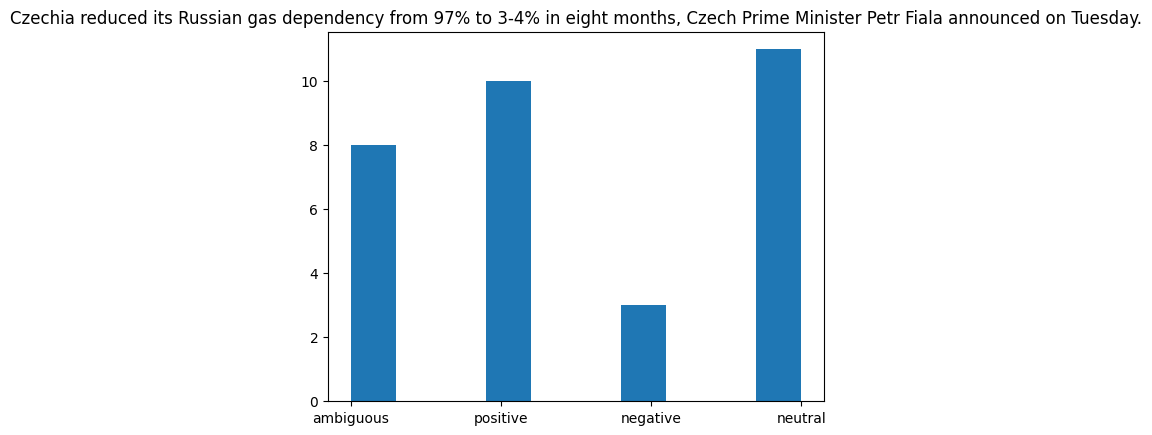

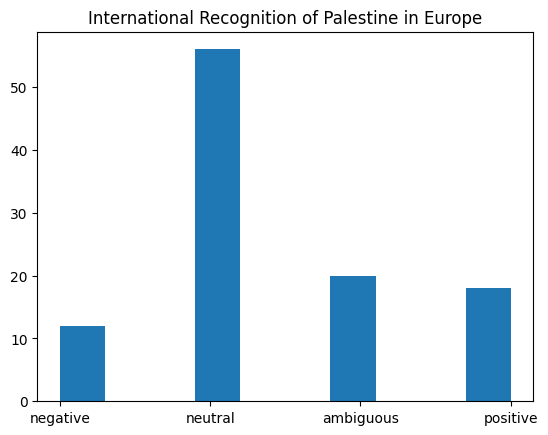

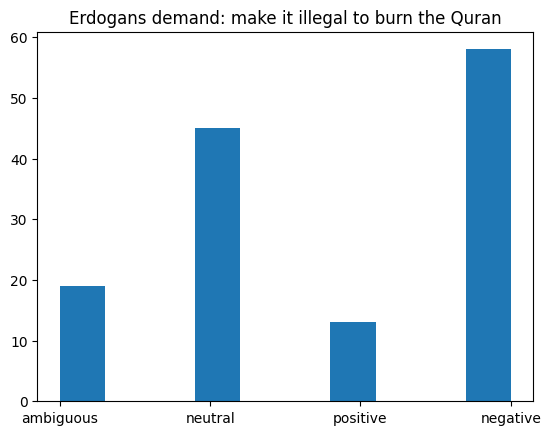

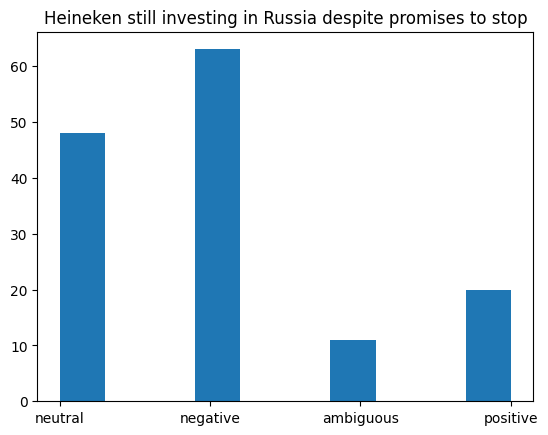

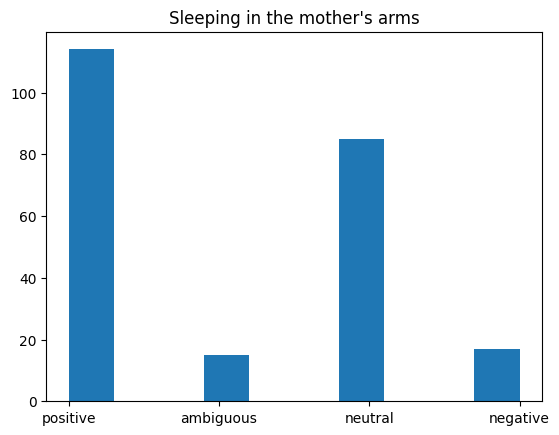

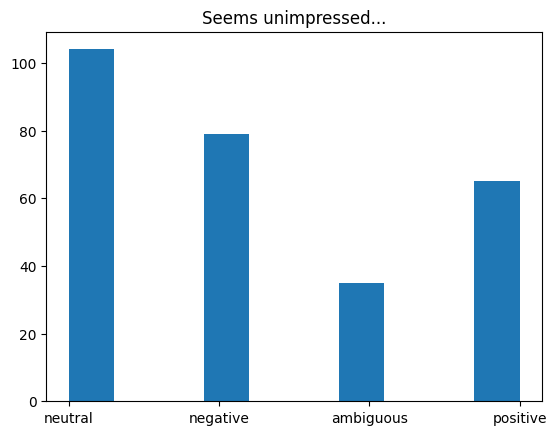

In [43]:
for n in range(0,9):
    t = np.transpose(sents[n])
    plt.hist(labelled_as[n])
    plt.title(data[0][n])
    plt.show()


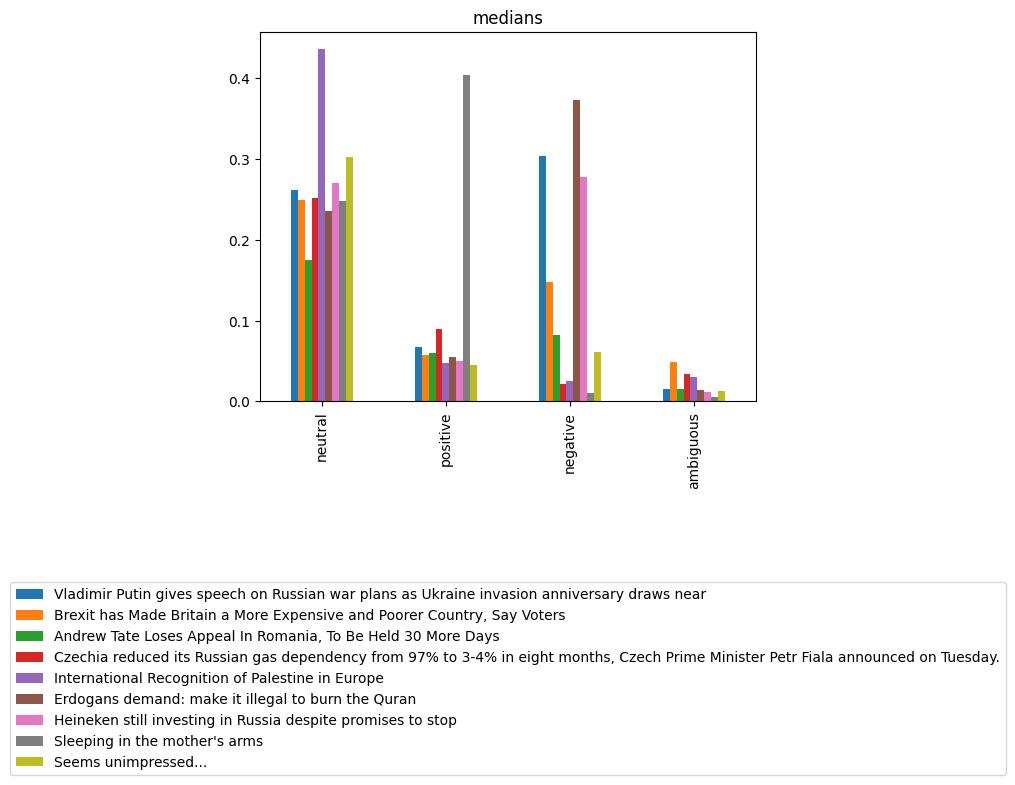

In [45]:
M = pd.DataFrame(medians,columns=['neutral','positive','negative','ambiguous'])    
m = M.T
fig,ax = plt.subplots()
m.plot(kind='bar',title='medians',ax=ax)
ax.legend(data[0].to_list(),loc=10,bbox_to_anchor=(0.5,-0.75));

In [46]:
stats = pd.DataFrame(zip(data[0],avgs,medians,std,most_common_sentiment),columns=
                     ['title','average sentiment','median sentiment value','sentiment standard deviation','most common sentiment'])

In [48]:
stats

,title,average sentiment,median sentiment value,sentiment standard deviation,most common sentiment
0,Vladimir Putin gives speech on Russian war pla...,"[0.3388791, 0.22691807, 0.37688774, 0.057315074]","[0.26105562, 0.06707084, 0.30380803, 0.01582802]","[0.28588587, 0.29546797, 0.32491744, 0.117013305]",negative
1,Brexit has Made Britain a More Expensive and P...,"[0.32275316, 0.17308702, 0.2901997, 0.21396007]","[0.24975325, 0.057553846, 0.14740193, 0.049073...","[0.28291234, 0.24702832, 0.30301443, 0.30857083]",neutral
2,"Andrew Tate Loses Appeal In Romania, To Be Hel...","[0.31863138, 0.28947616, 0.26820567, 0.123686805]","[0.17446254, 0.059672173, 0.08219178, 0.015050...","[0.3398806, 0.37400365, 0.33121204, 0.24233665]",neutral
3,Czechia reduced its Russian gas dependency fro...,"[0.3463188, 0.29508927, 0.13095483, 0.22763708]","[0.25209892, 0.089984044, 0.021371774, 0.03359...","[0.29772803, 0.3494343, 0.20035653, 0.32580405]",neutral
4,International Recognition of Palestine in Europe,"[0.49879614, 0.19654977, 0.13095064, 0.17370343]","[0.43551767, 0.04776066, 0.024794148, 0.030417...","[0.3447163, 0.30066207, 0.23197003, 0.27444032]",neutral
5,Erdogans demand: make it illegal to burn the Q...,"[0.3091742, 0.14068331, 0.43510425, 0.1150382]","[0.23568025, 0.05543187, 0.3727539, 0.014753009]","[0.2607825, 0.21614906, 0.34506708, 0.22360784]",negative
6,Heineken still investing in Russia despite pro...,"[0.3479654, 0.16820218, 0.40788174, 0.07595065]","[0.2706806, 0.050410792, 0.27747852, 0.012127862]","[0.30006385, 0.24741271, 0.36950573, 0.18012926]",negative
7,Sleeping in the mother's arms,"[0.37819642, 0.4727526, 0.08675239, 0.062298626]","[0.24809782, 0.4045161, 0.010852671, 0.0060926...","[0.3636588, 0.40742677, 0.20516117, 0.17054813]",positive
8,Seems unimpressed...,"[0.37382796, 0.24287194, 0.2673591, 0.11594106]","[0.30288225, 0.045670725, 0.060869504, 0.01243...","[0.31736863, 0.3485842, 0.32117492, 0.21787174]",neutral
